# Business Intelligence Course Evaluation Analysis
## Topic Modeling & Sentiment Analysis

**Objective**: Analyze student course evaluations using NLP to identify key themes and sentiments

**Datasets**: BBT 4106 (BI I) and BBT 4206 (BI II) course evaluations

## Section 1: Setup and Imports

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# NLP imports
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
import re

# Download NLTK data
print("Downloading NLTK data...")
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('vader_lexicon', quiet=True)
print("✓ NLTK data downloaded")

# Machine learning
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Model persistence
import joblib
import pickle
import json

# Visualization
from wordcloud import WordCloud
from collections import Counter
import scipy.stats as stats

# Set visualization defaults
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
pd.set_option('display.max_colwidth', None)

print("✓ All imports successful")

✓ NLTK data downloaded
✓ All imports successful


## Section 2: Load and Explore Data

In [11]:
# Load dataset
df = pd.read_csv('data/202511-ft_bi1_bi2_course_evaluation.csv')

print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"\nColumn names (first 10):")
for i, col in enumerate(df.columns[:10]):
    print(f"  {i+1}. {col}")
print(f"  ... and {len(df.columns)-10} more columns")

print(f"\nFirst row preview:")
df.head(1)

Dataset loaded successfully!
Shape: (130, 59)

Column names (first 10):
  1. timestamp
  2. consent
  3. a_1_student_id
  4. a_2_gender
  5. a_3_class_group
  6. b_1_i_enjoyed_the_course
  7. b_2_classes_started_and_ended_on_time
  8. b_3_participative_learning_environment
  9. b_4_subject_content_delivered_according_to_course_outline_and_my_expectations
  10. b_5_topics_were_clear_and_logically_developed
  ... and 49 more columns

First row preview:


,timestamp,consent,a_1_student_id,a_2_gender,a_3_class_group,b_1_i_enjoyed_the_course,b_2_classes_started_and_ended_on_time,b_3_participative_learning_environment,b_4_subject_content_delivered_according_to_course_outline_and_my_expectations,b_5_topics_were_clear_and_logically_developed,...,f_1_In_your_opinion_which_topics_(if_any)_should_be_added_to_the_Business_Intelligence_I_and_II_curriculum,f_2_In_your_opinion_which_topics_(if_any)_should_be_removed_from_the_Business_Intelligence_I_and_II_curriculum,f_3_Write_at_least_two_things_you_liked_about_the_teaching_and_learning_in_this_course,f_4_Write_at_least_one_recommendation_to_improve_the_teaching_and_learning_in_this_course_(for_future_classes),average_course_evaluation_rating,sentiment,average_level_of_learning_attained_rating,average_level_of_skills_and_competencies_rating,average_pedagogical_strategy_effectiveness_rating,absenteeism_percentage
0,06-11-25 8:19,"I CONSENT to my feedback being analyzed and used for educational and research purposes, provided that all data is fully anonymized.",1,Male,Group A,5,5,5,5,5,...,NaN,NaN,The teacher was engaging,More group time to work on group activities,4.9091,positive,4.0,1.6923,4.0833,40.91


In [12]:
# Check for missing values in key columns
print("Missing values in dataset:")
missing = df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("No missing values!")

Missing values in dataset:
f_1_In_your_opinion_which_topics_(if_any)_should_be_added_to_the_Business_Intelligence_I_and_II_curriculum        38
f_2_In_your_opinion_which_topics_(if_any)_should_be_removed_from_the_Business_Intelligence_I_and_II_curriculum    68
f_3_Write_at_least_two_things_you_liked_about_the_teaching_and_learning_in_this_course                             1
f_4_Write_at_least_one_recommendation_to_improve_the_teaching_and_learning_in_this_course_(for_future_classes)    12
dtype: int64


In [13]:
# Identify text columns for NLP analysis
text_columns = [
    'f_1_In_your_opinion_which_topics_(if_any)_should_be_added_to_the_Business_Intelligence_I_and_II_curriculum',
    'f_2_In_your_opinion_which_topics_(if_any)_should_be_removed_from_the_Business_Intelligence_I_and_II_curriculum',
    'f_3_Write_at_least_two_things_you_liked_about_the_teaching_and_learning_in_this_course',
    'f_4_Write_at_least_one_recommendation_to_improve_the_teaching_and_learning_in_this_course_(for_future_classes)'
]

print("TEXT COLUMNS ANALYSIS:")
print("="*60)
for col in text_columns:
    col_short = col.split('_', 1)[1][:45]
    non_null = df[col].notna().sum()
    print(f"\n{col_short}...")
    print(f"  Valid responses: {non_null}/{len(df)}")
    if non_null > 0:
        avg_length = df[col].dropna().str.len().mean()
        print(f"  Avg length: {avg_length:.0f} chars")

TEXT COLUMNS ANALYSIS:

1_In_your_opinion_which_topics_(if_any)_shoul...
  Valid responses: 92/130
  Avg length: 58 chars

2_In_your_opinion_which_topics_(if_any)_shoul...
  Valid responses: 62/130
  Avg length: 36 chars

3_Write_at_least_two_things_you_liked_about_t...
  Valid responses: 129/130
  Avg length: 102 chars

4_Write_at_least_one_recommendation_to_improv...
  Valid responses: 118/130
  Avg length: 86 chars


## Section 3: Text Preprocessing

In [14]:
# Initialize text processing tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Add domain-specific stop words
domain_stop_words = {'course', 'class', 'unit', 'would', 'could', 'one', 'like', 'also', 
                     'please', 'think', 'feel', 'make', 'try', 'way', 'thing', 'get', 'go'}
stop_words.update(domain_stop_words)

def preprocess_text(text):
    """Clean and preprocess text for NLP analysis"""
    if pd.isna(text) or text is None:
        return ""
    
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(token) for token in tokens 
              if token not in stop_words and len(token) > 2]
    
    return ' '.join(tokens)

# Test preprocessing
test_text = "The labs were really engaging and helped me understand the concepts better!"
print(f"Original: {test_text}")
print(f"Processed: {preprocess_text(test_text)}")

Original: The labs were really engaging and helped me understand the concepts better!
Processed: lab really engaging helped understand concept better


In [15]:
# Combine all text columns and preprocess
print("Processing all evaluations...")

df['combined_text'] = df[text_columns].fillna('').agg(' '.join, axis=1)
df['processed_text'] = df['combined_text'].apply(preprocess_text)
df['text_length'] = df['processed_text'].str.split().str.len()

# Filter out very short responses
df_filtered = df[df['text_length'] >= 3].copy()

print(f"\nProcessing complete!")
print(f"Records with meaningful text: {len(df_filtered)}/{len(df)}")
print(f"Average tokens per response: {df_filtered['text_length'].mean():.1f}")
print(f"\nSample processed text:")
print(df_filtered['processed_text'].iloc[0][:200])

Processing all evaluations...

Processing complete!
Records with meaningful text: 126/130
Average tokens per response: 20.8

Sample processed text:
teacher engaging group time work group activity


## Section 4: Word Frequency Analysis

In [16]:
# Get top words across all evaluations
all_words = ' '.join(df_filtered['processed_text']).split()
word_freq = Counter(all_words)
top_words = word_freq.most_common(30)

print("Top 30 Most Common Words:")
print("="*40)
for i, (word, count) in enumerate(top_words, 1):
    print(f"{i:2d}. {word:15s} : {count:3d}")

Top 30 Most Common Words:
 1. lab             :  83
 2. topic           :  59
 3. none            :  52
 4. practical       :  45
 5. work            :  39
 6. content         :  34
 7. data            :  34
 8. slide           :  34
 9. concept         :  31
10. business        :  26
11. liked           :  26
12. group           :  25
13. module          :  24
14. understanding   :  23
15. learning        :  23
16. lecturer        :  23
17. quiz            :  20
18. intelligence    :  19
19. assignment      :  19
20. note            :  18
21. real            :  18
22. understand      :  18
23. theory          :  17
24. well            :  16
25. application     :  16
26. student         :  16
27. better          :  15
28. opinion         :  14
29. lecture         :  14
30. tool            :  14


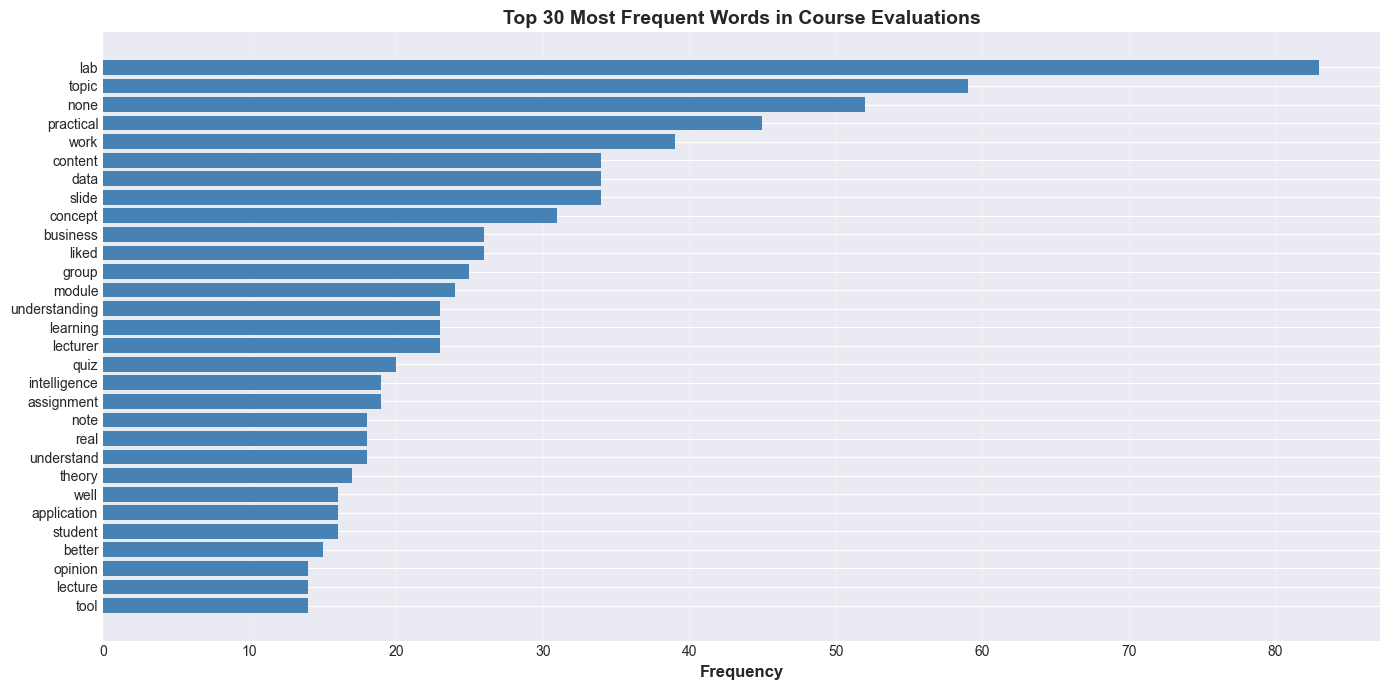

✓ Saved visualization: word_frequency.png


In [17]:
# Visualize word frequencies
fig, ax = plt.subplots(figsize=(14, 7))
words, freqs = zip(*top_words)
ax.barh(range(len(words)), freqs, color='steelblue')
ax.set_yticks(range(len(words)))
ax.set_yticklabels(words)
ax.invert_yaxis()
ax.set_xlabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('Top 30 Most Frequent Words in Course Evaluations', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('word_frequency.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved visualization: word_frequency.png")

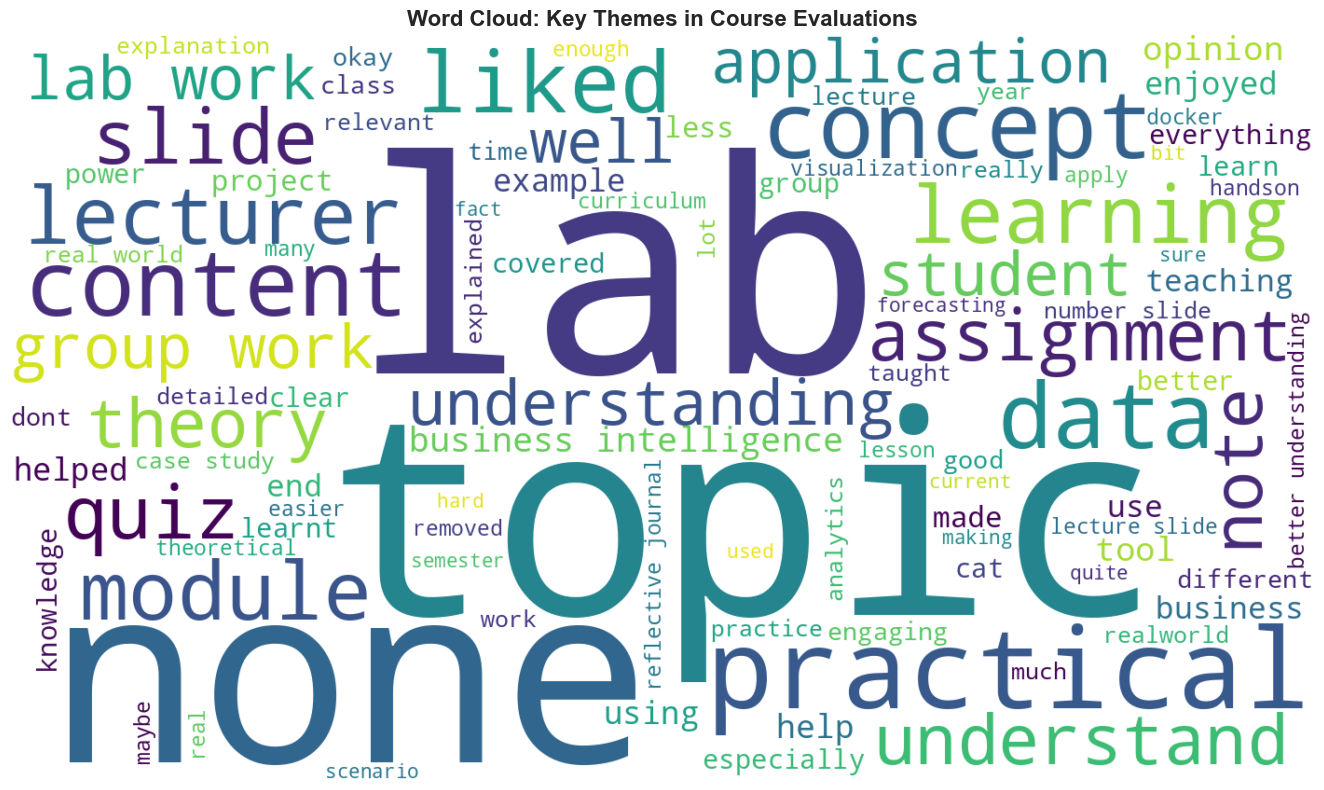

✓ Saved visualization: wordcloud.png


In [18]:
# Word cloud visualization
fig, ax = plt.subplots(figsize=(14, 8))
wordcloud = WordCloud(width=1400, height=800, background_color='white', 
                       colormap='viridis', max_words=100).generate(' '.join(df_filtered['processed_text']))
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis('off')
ax.set_title('Word Cloud: Key Themes in Course Evaluations', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('wordcloud.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved visualization: wordcloud.png")

## Section 5: Topic Modeling with LDA

In [19]:
# Create document-term matrix for LDA
print("Creating document-term matrix...")

count_vectorizer = CountVectorizer(
    max_features=200,
    min_df=2,
    max_df=0.8,
    stop_words='english'
)

doc_term_matrix = count_vectorizer.fit_transform(df_filtered['processed_text'])
feature_names = count_vectorizer.get_feature_names_out()

print(f"\nDocument-Term Matrix:")
print(f"  Shape: {doc_term_matrix.shape}")
print(f"  Vocabulary size: {len(feature_names)}")
print(f"  Sparsity: {1 - (doc_term_matrix.nnz / (doc_term_matrix.shape[0] * doc_term_matrix.shape[1]))*100:.2f}%")

Creating document-term matrix...

Document-Term Matrix:
  Shape: (126, 200)
  Vocabulary size: 200
  Sparsity: -4.47%


In [20]:
# Train LDA model
print("Training LDA model (this may take a moment)...")
n_topics = 5

lda_model = LDA(
    n_components=n_topics,
    random_state=42,
    max_iter=20,
    learning_method='online',
    n_jobs=-1,
    verbose=0
)

lda_output = lda_model.fit_transform(doc_term_matrix)
print(f"\n✓ LDA model trained successfully!")
print(f"Output shape: {lda_output.shape}")

Training LDA model (this may take a moment)...

✓ LDA model trained successfully!
Output shape: (126, 5)


In [21]:
# Extract and display topics
def display_topics(model, feature_names, n_top_words=15):
    topics_dict = {}
    print("\nTOPIC MODELING RESULTS")
    print("="*80)
    
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[-n_top_words:][::-1]
        top_words = [feature_names[i] for i in top_words_idx]
        topics_dict[f'Topic {topic_idx}'] = top_words
        
        print(f"\nTopic {topic_idx}:")
        print("-" * 60)
        print(", ".join(top_words))
    
    return topics_dict

topics = display_topics(lda_model, feature_names, n_top_words=15)


TOPIC MODELING RESULTS

Topic 0:
------------------------------------------------------------
liked, lab, practical, slide, content, topic, number, data, note, time, reduce, module, lecturer, learning, teaching

Topic 1:
------------------------------------------------------------
cat, point, end, note, learning, maybe, depth, quiz, covered, year, lecturer, dont, sure, issue, understand

Topic 2:
------------------------------------------------------------
lab, topic, work, concept, slide, understanding, content, module, practical, lecturer, assignment, group, better, application, understand

Topic 3:
------------------------------------------------------------
data, business, practical, learning, tool, intelligence, project, student, understand, study, case, topic, using, handson, theory

Topic 4:
------------------------------------------------------------
group, work, assignment, moment, matter, opinion, far, okay, relevant, practical, data, really, module, helped, research


In [22]:
# Assign dominant topic to each document
dominant_topics = lda_output.argmax(axis=1)
dominant_topic_weights = lda_output.max(axis=1)

df_filtered['dominant_topic'] = dominant_topics
df_filtered['topic_weight'] = dominant_topic_weights

# Topic distribution
print("\nTopic Distribution:")
print("="*40)
topic_dist = df_filtered['dominant_topic'].value_counts().sort_index()
for topic, count in topic_dist.items():
    pct = (count / len(df_filtered)) * 100
    print(f"Topic {topic}: {count:3d} documents ({pct:5.1f}%)")

print(f"\nAverage topic confidence: {dominant_topic_weights.mean():.3f}")


Topic Distribution:
Topic 0:  37 documents ( 29.4%)
Topic 1:  11 documents (  8.7%)
Topic 2:  48 documents ( 38.1%)
Topic 3:  16 documents ( 12.7%)
Topic 4:  14 documents ( 11.1%)

Average topic confidence: 0.831


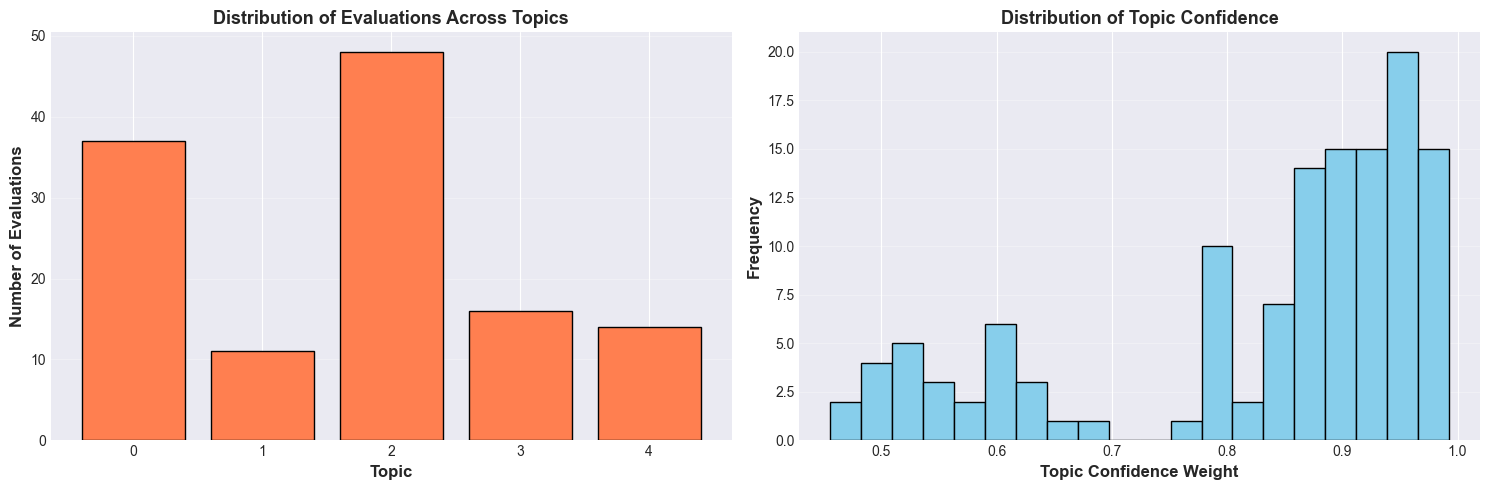

✓ Saved visualization: topic_distribution.png


In [23]:
# Visualize topic distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar chart of topic counts
topic_counts = [topic_dist.get(i, 0) for i in range(n_topics)]
axes[0].bar(range(n_topics), topic_counts, color='coral', edgecolor='black')
axes[0].set_xlabel('Topic', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Evaluations', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution of Evaluations Across Topics', fontsize=13, fontweight='bold')
axes[0].set_xticks(range(n_topics))
axes[0].grid(axis='y', alpha=0.3)

# Histogram of topic confidence
axes[1].hist(dominant_topic_weights, bins=20, color='skyblue', edgecolor='black')
axes[1].set_xlabel('Topic Confidence Weight', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1].set_title('Distribution of Topic Confidence', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('topic_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved visualization: topic_distribution.png")

## Section 6: Sentiment Analysis

In [24]:
# Perform sentiment analysis using VADER
print("Performing sentiment analysis...")

sia = SentimentIntensityAnalyzer()

sentiments = []
compound_scores = []
pos_scores = []
neg_scores = []
neu_scores = []

for text in tqdm(df_filtered['combined_text'], desc="Analyzing"):
    scores = sia.polarity_scores(text)
    compound_scores.append(scores['compound'])
    pos_scores.append(scores['pos'])
    neg_scores.append(scores['neg'])
    neu_scores.append(scores['neu'])
    
    # Classify sentiment
    if scores['compound'] >= 0.05:
        sentiments.append('positive')
    elif scores['compound'] <= -0.05:
        sentiments.append('negative')
    else:
        sentiments.append('neutral')

df_filtered['sentiment'] = sentiments
df_filtered['sentiment_score'] = compound_scores
df_filtered['pos_score'] = pos_scores
df_filtered['neg_score'] = neg_scores
df_filtered['neu_score'] = neu_scores

print(f"\n✓ Sentiment analysis complete!")
print(f"\nSentiment Distribution:")
print("="*40)
sentiment_dist = df_filtered['sentiment'].value_counts()
for sent, count in sentiment_dist.items():
    pct = (count / len(df_filtered)) * 100
    print(f"{sent:10s}: {count:3d} ({pct:5.1f}%)")

Performing sentiment analysis...


Analyzing: 100%|██████████| 126/126 [00:00<00:00, 4261.06it/s]


✓ Sentiment analysis complete!

Sentiment Distribution:
positive  :  87 ( 69.0%)
neutral   :  28 ( 22.2%)
negative  :  11 (  8.7%)


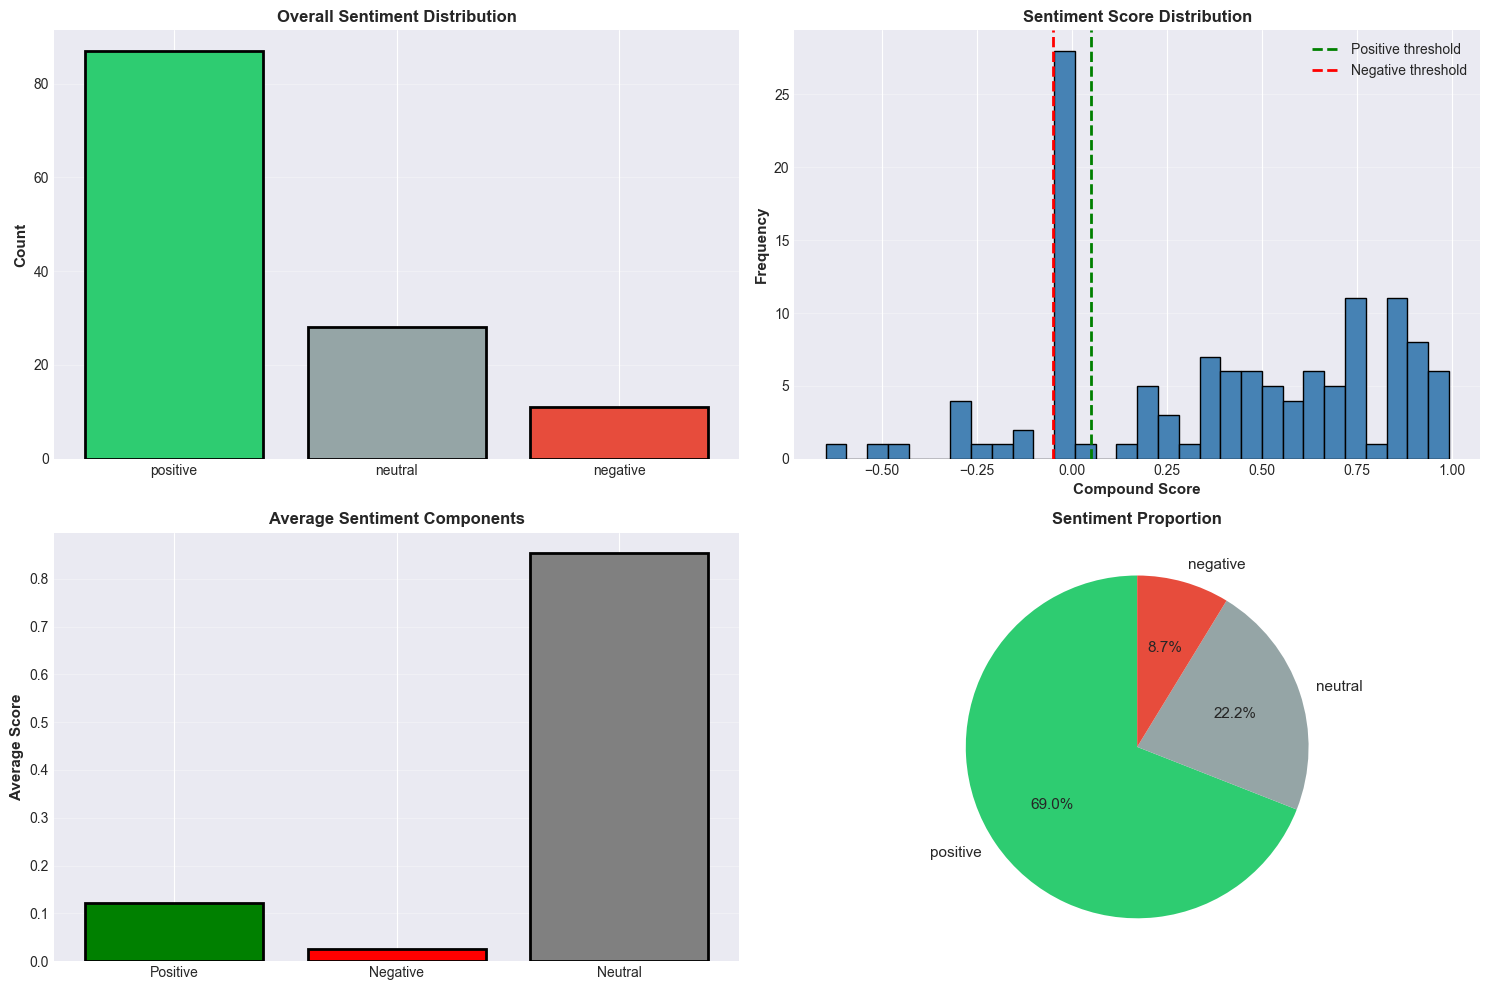

✓ Saved visualization: sentiment_analysis.png


In [25]:
# Visualize sentiment analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Sentiment distribution
sentiment_counts = df_filtered['sentiment'].value_counts()
colors = {'positive': '#2ecc71', 'neutral': '#95a5a6', 'negative': '#e74c3c'}
color_list = [colors.get(x, 'blue') for x in sentiment_counts.index]

axes[0, 0].bar(sentiment_counts.index, sentiment_counts.values, color=color_list, edgecolor='black', linewidth=2)
axes[0, 0].set_ylabel('Count', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Overall Sentiment Distribution', fontsize=12, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)

# Compound score distribution
axes[0, 1].hist(df_filtered['sentiment_score'], bins=30, color='steelblue', edgecolor='black')
axes[0, 1].axvline(x=0.05, color='green', linestyle='--', linewidth=2, label='Positive threshold')
axes[0, 1].axvline(x=-0.05, color='red', linestyle='--', linewidth=2, label='Negative threshold')
axes[0, 1].set_xlabel('Compound Score', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Sentiment Score Distribution', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# Average sentiment components
components = ['Positive', 'Negative', 'Neutral']
averages = [df_filtered['pos_score'].mean(), df_filtered['neg_score'].mean(), df_filtered['neu_score'].mean()]
axes[1, 0].bar(components, averages, color=['green', 'red', 'gray'], edgecolor='black', linewidth=2)
axes[1, 0].set_ylabel('Average Score', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Average Sentiment Components', fontsize=12, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# Pie chart
axes[1, 1].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%',
               colors=color_list, startangle=90, textprops={'fontsize': 11})
axes[1, 1].set_title('Sentiment Proportion', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('sentiment_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved visualization: sentiment_analysis.png")

## Section 7: Topic-Sentiment Relationship

In [26]:
# Analyze sentiment by topic
print("\nSentiment Distribution by Topic:")
print("="*60)
topic_sentiment = pd.crosstab(df_filtered['dominant_topic'], df_filtered['sentiment'])
print(topic_sentiment)

# Percentage breakdown
print("\nPercentage breakdown by topic:")
topic_sentiment_pct = pd.crosstab(df_filtered['dominant_topic'], df_filtered['sentiment'], normalize='index') * 100
print(topic_sentiment_pct.round(1))


Sentiment Distribution by Topic:
sentiment       negative  neutral  positive
dominant_topic                             
0                      4        7        26
1                      2        3         6
2                      2       10        36
3                      1        3        12
4                      2        5         7

Percentage breakdown by topic:
sentiment       negative  neutral  positive
dominant_topic                             
0                   10.8     18.9      70.3
1                   18.2     27.3      54.5
2                    4.2     20.8      75.0
3                    6.2     18.8      75.0
4                   14.3     35.7      50.0


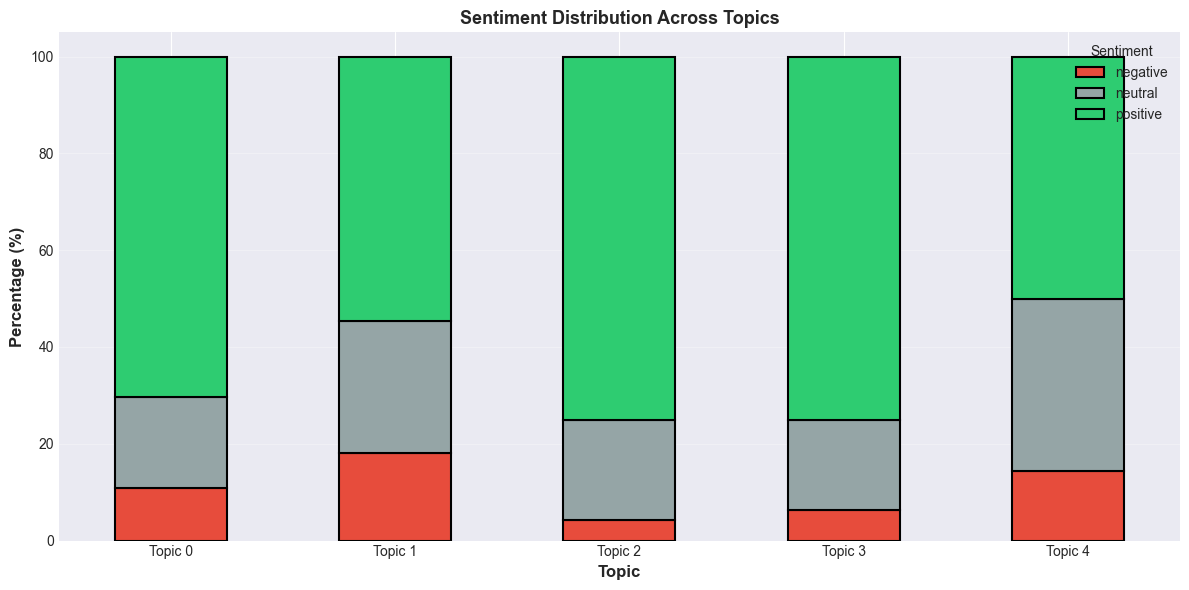

✓ Saved visualization: topic_sentiment.png


In [27]:
# Visualize topic-sentiment relationship
fig, ax = plt.subplots(figsize=(12, 6))
topic_sentiment_pct = pd.crosstab(df_filtered['dominant_topic'], df_filtered['sentiment'], normalize='index') * 100
topic_sentiment_pct.plot(kind='bar', stacked=True, ax=ax, 
                         color=['#e74c3c', '#95a5a6', '#2ecc71'],
                         edgecolor='black', linewidth=1.5)
ax.set_xlabel('Topic', fontsize=12, fontweight='bold')
ax.set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
ax.set_title('Sentiment Distribution Across Topics', fontsize=13, fontweight='bold')
ax.legend(title='Sentiment', loc='upper right')
ax.set_xticklabels([f'Topic {i}' for i in range(n_topics)], rotation=0)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('topic_sentiment.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved visualization: topic_sentiment.png")

## Section 8: Deep Exploratory Analysis


RQ1: TOPIC DISTRIBUTION BY CLASS GROUP

Count of evaluations by Group and Topic:
dominant_topic    0  1   2  3  4
a_3_class_group                 
Group A          13  3  15  4  4
Group B          13  4  14  7  3
Group C          11  4  19  5  7

Percentage breakdown (within each group):
dominant_topic      0    1     2     3     4
a_3_class_group                             
Group A          33.3  7.7  38.5  10.3  10.3
Group B          31.7  9.8  34.1  17.1   7.3
Group C          23.9  8.7  41.3  10.9  15.2


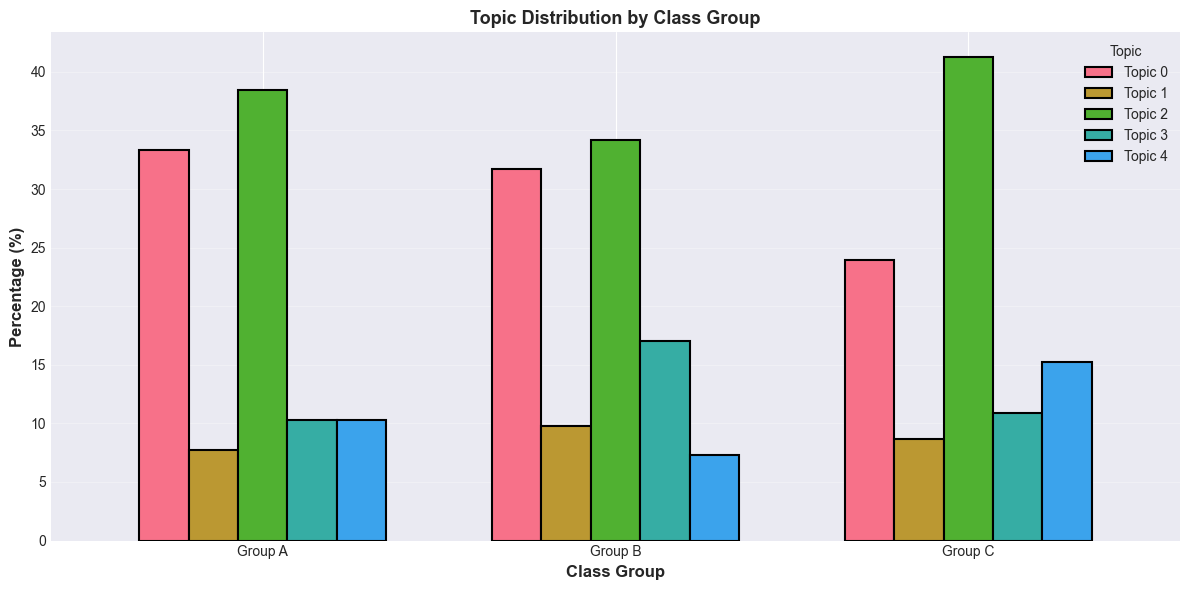


✓ Saved visualization: topics_by_group.png


In [28]:
# RQ1: Topics by Class Group
print("\n" + "="*80)
print("RQ1: TOPIC DISTRIBUTION BY CLASS GROUP")
print("="*80)

if 'a_3_class_group' in df_filtered.columns:
    topic_by_group = pd.crosstab(df_filtered['a_3_class_group'], df_filtered['dominant_topic'])
    print("\nCount of evaluations by Group and Topic:")
    print(topic_by_group)
    
    # Percentage breakdown
    print("\nPercentage breakdown (within each group):")
    topic_by_group_pct = pd.crosstab(df_filtered['a_3_class_group'], df_filtered['dominant_topic'], normalize='index') * 100
    print(topic_by_group_pct.round(1))
    
    # Visualize
    fig, ax = plt.subplots(figsize=(12, 6))
    topic_by_group_pct.plot(kind='bar', ax=ax, width=0.7, edgecolor='black', linewidth=1.5)
    ax.set_xlabel('Class Group', fontsize=12, fontweight='bold')
    ax.set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
    ax.set_title('Topic Distribution by Class Group', fontsize=13, fontweight='bold')
    ax.legend(title='Topic', labels=[f'Topic {i}' for i in range(n_topics)], loc='best')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('topics_by_group.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("\n✓ Saved visualization: topics_by_group.png")
else:
    print("Class group column not found in data")


RQ2: TOPICS BY 'I ENJOYED THE COURSE' RATING

Count of evaluations by Enjoyment and Topic:
dominant_topic     0  1   2   3   4
enjoyed_category                   
Low (1-2.5)        2  1   4   1   0
Medium (2.5-3.5)   8  2   8   4   3
High (3.5-5)      27  8  36  11  11

Average sentiment score by enjoyment level:
                   mean  count    std
enjoyed_category                     
Low (1-2.5)       0.435      8  0.357
Medium (2.5-3.5)  0.365     25  0.346
High (3.5-5)      0.406     93  0.415


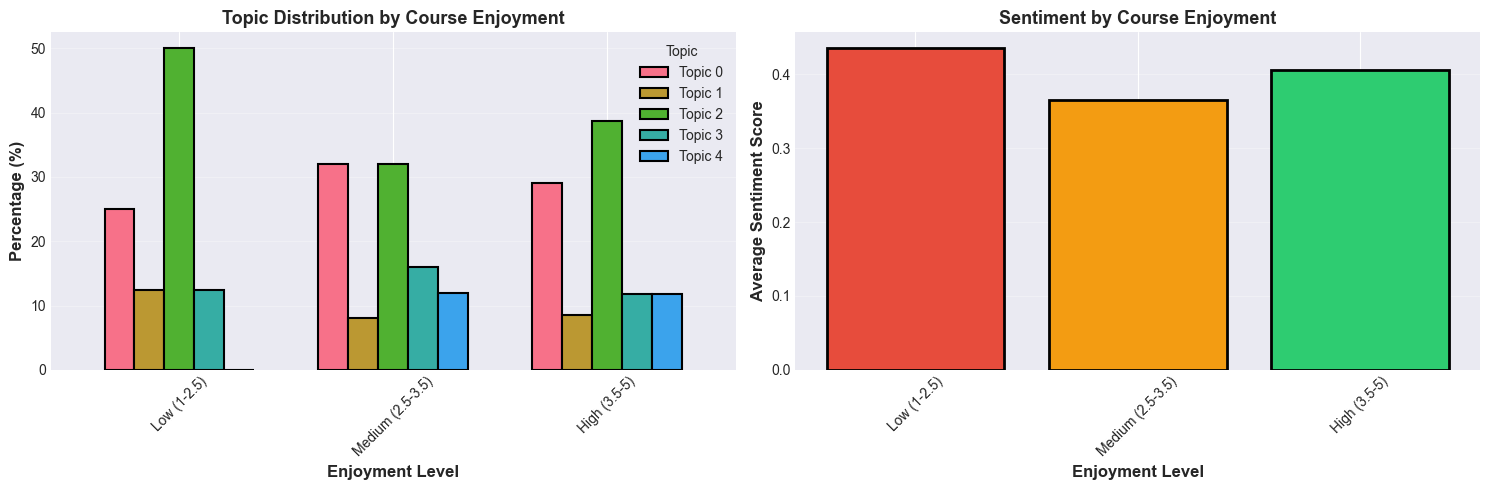


✓ Saved visualization: topics_by_enjoyment.png


In [29]:
# RQ2: Topics from high vs low "enjoyed" ratings
print("\n" + "="*80)
print("RQ2: TOPICS BY 'I ENJOYED THE COURSE' RATING")
print("="*80)

if 'b_1_i_enjoyed_the_course' in df_filtered.columns:
    # Create rating categories
    df_filtered['enjoyed_category'] = pd.cut(df_filtered['b_1_i_enjoyed_the_course'],
                                              bins=[0, 2.5, 3.5, 5],
                                              labels=['Low (1-2.5)', 'Medium (2.5-3.5)', 'High (3.5-5)'])
    
    topic_by_enjoyed = pd.crosstab(df_filtered['enjoyed_category'], df_filtered['dominant_topic'])
    print("\nCount of evaluations by Enjoyment and Topic:")
    print(topic_by_enjoyed)
    
    # Sentiment by enjoyment
    print(f"\nAverage sentiment score by enjoyment level:")
    enjoyment_sentiment = df_filtered.groupby('enjoyed_category')['sentiment_score'].agg(['mean', 'count', 'std'])
    print(enjoyment_sentiment.round(3))
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Topic distribution
    topic_by_enjoyed_pct = pd.crosstab(df_filtered['enjoyed_category'], df_filtered['dominant_topic'], normalize='index') * 100
    topic_by_enjoyed_pct.plot(kind='bar', ax=axes[0], width=0.7, edgecolor='black', linewidth=1.5)
    axes[0].set_xlabel('Enjoyment Level', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
    axes[0].set_title('Topic Distribution by Course Enjoyment', fontsize=13, fontweight='bold')
    axes[0].legend(title='Topic', labels=[f'Topic {i}' for i in range(n_topics)], loc='best')
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
    axes[0].grid(axis='y', alpha=0.3)
    
    # Sentiment by enjoyment
    axes[1].bar(range(len(enjoyment_sentiment)), enjoyment_sentiment['mean'].values,
                color=['#e74c3c', '#f39c12', '#2ecc71'], edgecolor='black', linewidth=2)
    axes[1].set_xticks(range(len(enjoyment_sentiment)))
    axes[1].set_xticklabels(enjoyment_sentiment.index, rotation=45)
    axes[1].set_ylabel('Average Sentiment Score', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Enjoyment Level', fontsize=12, fontweight='bold')
    axes[1].set_title('Sentiment by Course Enjoyment', fontsize=13, fontweight='bold')
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('topics_by_enjoyment.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("\n✓ Saved visualization: topics_by_enjoyment.png")
else:
    print("Enjoyment rating column not found")


RQ3: ABSENTEEISM & COURSE EVALUATION CORRELATION

Correlation (Absenteeism vs Course Rating): -0.142
Correlation (Absenteeism vs Sentiment): -0.121

Average Metrics by Absenteeism Level:
                 average_course_evaluation_rating       sentiment_score
                                             mean count            mean
absenteeism_cat                                                        
Very Low (0-10%)                            4.387    51           0.458
Low (10-20%)                                4.141    40           0.396
Medium (20-35%)                             4.037    32           0.308
High (35%+)                                 4.727     3           0.419


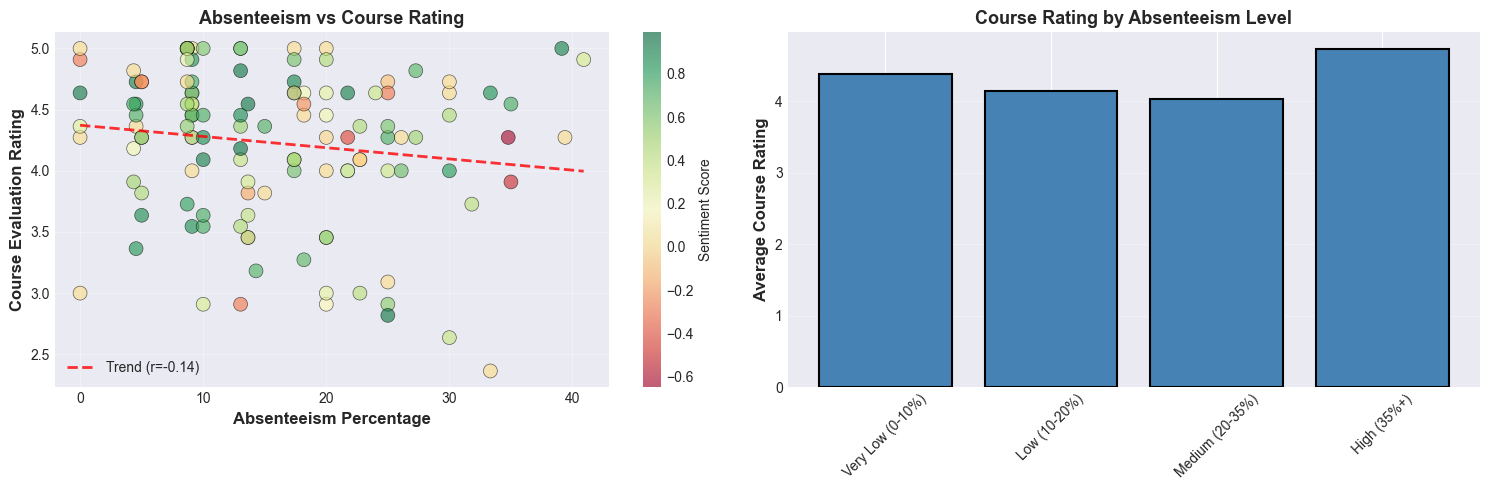


✓ Saved visualization: absenteeism_impact.png


In [30]:
# RQ3: Absenteeism and course ratings correlation
print("\n" + "="*80)
print("RQ3: ABSENTEEISM & COURSE EVALUATION CORRELATION")
print("="*80)

if 'absenteeism_percentage' in df_filtered.columns and 'average_course_evaluation_rating' in df_filtered.columns:
    # Calculate correlations
    corr_rating = df_filtered['absenteeism_percentage'].corr(df_filtered['average_course_evaluation_rating'])
    corr_sentiment = df_filtered['absenteeism_percentage'].corr(df_filtered['sentiment_score'])
    
    print(f"\nCorrelation (Absenteeism vs Course Rating): {corr_rating:.3f}")
    print(f"Correlation (Absenteeism vs Sentiment): {corr_sentiment:.3f}")
    
    # Create absenteeism categories
    df_filtered['absenteeism_cat'] = pd.cut(df_filtered['absenteeism_percentage'],
                                             bins=[-1, 10, 20, 35, 100],
                                             labels=['Very Low (0-10%)', 'Low (10-20%)', 'Medium (20-35%)', 'High (35%+)'])
    
    print(f"\nAverage Metrics by Absenteeism Level:")
    abs_impact = df_filtered.groupby('absenteeism_cat').agg({
        'average_course_evaluation_rating': ['mean', 'count'],
        'sentiment_score': 'mean'
    }).round(3)
    print(abs_impact)
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Scatter with trend line
    scatter = axes[0].scatter(df_filtered['absenteeism_percentage'], 
                             df_filtered['average_course_evaluation_rating'],
                             alpha=0.6, s=100, c=df_filtered['sentiment_score'], 
                             cmap='RdYlGn', edgecolors='black', linewidth=0.5)
    z = np.polyfit(df_filtered['absenteeism_percentage'], df_filtered['average_course_evaluation_rating'], 1)
    p = np.poly1d(z)
    x_sorted = np.sort(df_filtered['absenteeism_percentage'])
    axes[0].plot(x_sorted, p(x_sorted), "r--", alpha=0.8, linewidth=2, 
                label=f'Trend (r={corr_rating:.2f})')
    axes[0].set_xlabel('Absenteeism Percentage', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Course Evaluation Rating', fontsize=12, fontweight='bold')
    axes[0].set_title('Absenteeism vs Course Rating', fontsize=13, fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    plt.colorbar(scatter, ax=axes[0], label='Sentiment Score')
    
    # Bar plot by category
    abs_means = df_filtered.groupby('absenteeism_cat')['average_course_evaluation_rating'].mean()
    axes[1].bar(range(len(abs_means)), abs_means.values, 
               color='steelblue', edgecolor='black', linewidth=1.5)
    axes[1].set_xticks(range(len(abs_means)))
    axes[1].set_xticklabels(abs_means.index, rotation=45)
    axes[1].set_ylabel('Average Course Rating', fontsize=12, fontweight='bold')
    axes[1].set_title('Course Rating by Absenteeism Level', fontsize=13, fontweight='bold')
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('absenteeism_impact.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("\n✓ Saved visualization: absenteeism_impact.png")
else:
    print("Required columns not found")


RQ4: ABSENTEEISM & CLASS PUNCTUALITY

Correlation (Absenteeism vs Punctuality): 0.018

Average Punctuality Rating by Absenteeism Level:
                  mean  count
absenteeism_cat              
Very Low (0-10%)  4.76     51
Low (10-20%)      4.55     40
Medium (20-35%)   4.75     32
High (35%+)       5.00      3


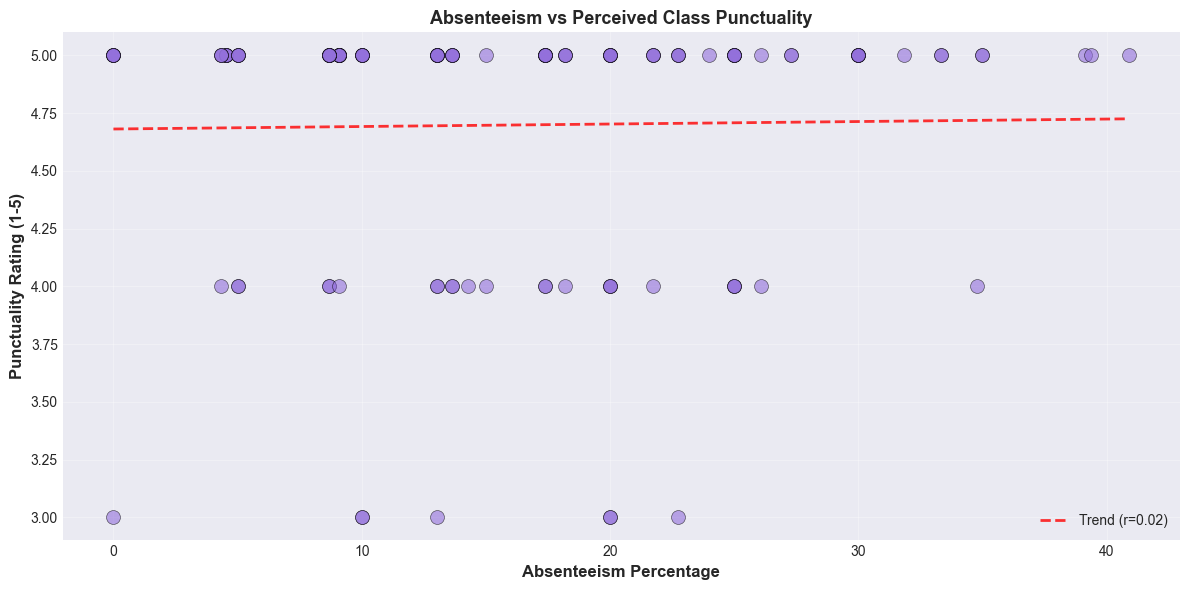


✓ Saved visualization: absenteeism_punctuality.png


In [31]:
# RQ4: Absenteeism and class punctuality
print("\n" + "="*80)
print("RQ4: ABSENTEEISM & CLASS PUNCTUALITY")
print("="*80)

if 'b_2_classes_started_and_ended_on_time' in df_filtered.columns:
    corr_punct = df_filtered['absenteeism_percentage'].corr(df_filtered['b_2_classes_started_and_ended_on_time'])
    print(f"\nCorrelation (Absenteeism vs Punctuality): {corr_punct:.3f}")
    
    print(f"\nAverage Punctuality Rating by Absenteeism Level:")
    punct_stats = df_filtered.groupby('absenteeism_cat')['b_2_classes_started_and_ended_on_time'].agg(['mean', 'count'])
    print(punct_stats.round(2))
    
    # Visualize
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.scatter(df_filtered['absenteeism_percentage'], df_filtered['b_2_classes_started_and_ended_on_time'],
              alpha=0.6, s=100, color='mediumpurple', edgecolors='black', linewidth=0.5)
    z = np.polyfit(df_filtered['absenteeism_percentage'], df_filtered['b_2_classes_started_and_ended_on_time'], 1)
    p = np.poly1d(z)
    x_sorted = np.sort(df_filtered['absenteeism_percentage'])
    ax.plot(x_sorted, p(x_sorted), "r--", alpha=0.8, linewidth=2, 
           label=f'Trend (r={corr_punct:.2f})')
    ax.set_xlabel('Absenteeism Percentage', fontsize=12, fontweight='bold')
    ax.set_ylabel('Punctuality Rating (1-5)', fontsize=12, fontweight='bold')
    ax.set_title('Absenteeism vs Perceived Class Punctuality', fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('absenteeism_punctuality.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("\n✓ Saved visualization: absenteeism_punctuality.png")
else:
    print("Punctuality column not found")

In [32]:
# RQ5: Understanding "More Engagement" theme
print("\n" + "="*80)
print("RQ5: WHAT DOES 'MORE ENGAGEMENT' MEAN?")
print("="*80)

# Find recommendations mentioning "engagement"
f4_col = 'f_4_Write_at_least_one_recommendation_to_improve_the_teaching_and_learning_in_this_course_(for_future_classes)'
if f4_col in df.columns:
    engagement_mask = df[f4_col].str.contains('engagement', case=False, na=False)
    engagement_responses = df[engagement_mask][f4_col].dropna()
    
    print(f"\nNumber of responses mentioning 'engagement': {len(engagement_responses)}")
    print(f"\nSample responses about engagement:")
    print("="*80)
    for i, response in enumerate(engagement_responses.head(5), 1):
        print(f"\n{i}. {response[:200]}...")
    
    # Analyze key themes in engagement recommendations
    engagement_text = ' '.join(engagement_responses)
    engagement_processed = preprocess_text(engagement_text)
    engagement_words = Counter(engagement_processed.split()).most_common(20)
    
    print(f"\n\nTop words in 'engagement' recommendations:")
    print("="*40)
    for word, count in engagement_words:
        print(f"{word:20s} : {count:2d}")
else:
    print("Recommendation column not found")


RQ5: WHAT DOES 'MORE ENGAGEMENT' MEAN?

Number of responses mentioning 'engagement': 3

Sample responses about engagement:

1. Introduce small class engagements and all...

2. More engagements, not just completing the labs
And the university's machines were crashing sometimes on heavy labs on data engineering...

3. More assignments and quizzes for more active engagement with the unit...


Top words in 'engagement' recommendations:
engagement           :  3
lab                  :  2
introduce            :  1
small                :  1
completing           :  1
university           :  1
machine              :  1
crashing             :  1
sometimes            :  1
heavy                :  1
data                 :  1
engineering          :  1
assignment           :  1
quiz                 :  1
active               :  1



COMMON RECOMMENDATION THEMES ANALYSIS

Recommendation Theme Frequency:
Reduce Slides/Content          :  34 ( 26.2%)
More Assessment                :  30 ( 23.1%)
More Labs/Practical            :  18 ( 13.8%)
Real-world Focus               :  14 ( 10.8%)
Interactive Learning           :  12 (  9.2%)
Better Clarity                 :   8 (  6.2%)


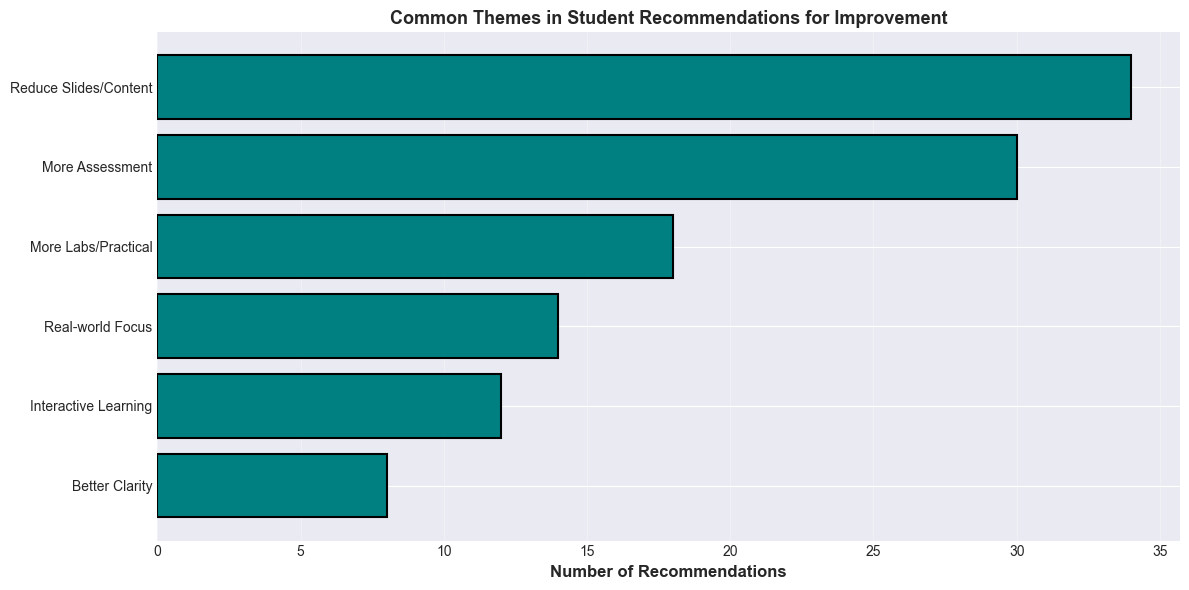


✓ Saved visualization: recommendation_themes.png


In [33]:
# Analyze common recommendation themes
print("\n" + "="*80)
print("COMMON RECOMMENDATION THEMES ANALYSIS")
print("="*80)

# Define theme keywords
themes = {
    'Reduce Slides/Content': ['slides', 'notes', 'content', 'pages', 'bulky', 'overwhelming', 'reduce', 'shorter'],
    'More Labs/Practical': ['labs', 'practical', 'hands on', 'tutorial', 'example', 'hands-on'],
    'Interactive Learning': ['engagement', 'interactive', 'participation', 'discussion', 'group', 'involve'],
    'More Assessment': ['quiz', 'assignment', 'cat', 'exam', 'assessment', 'test'],
    'Better Clarity': ['clarity', 'clear', 'step', 'guide', 'explain', 'simple'],
    'Real-world Focus': ['real world', 'practical', 'application', 'industry', 'case study', 'business']
}

theme_counts = {theme: 0 for theme in themes.keys()}

f4_col = 'f_4_Write_at_least_one_recommendation_to_improve_the_teaching_and_learning_in_this_course_(for_future_classes)'
if f4_col in df.columns:
    for recommendation in df[f4_col].dropna():
        text_lower = recommendation.lower()
        for theme, keywords in themes.items():
            if any(keyword in text_lower for keyword in keywords):
                theme_counts[theme] += 1

print("\nRecommendation Theme Frequency:")
print("="*50)
for theme, count in sorted(theme_counts.items(), key=lambda x: x[1], reverse=True):
    pct = (count / len(df)) * 100
    print(f"{theme:30s} : {count:3d} ({pct:5.1f}%)")

# Visualize themes
fig, ax = plt.subplots(figsize=(12, 6))
themes_sorted = sorted(theme_counts.items(), key=lambda x: x[1], reverse=True)
theme_names, theme_freqs = zip(*themes_sorted)
ax.barh(range(len(theme_names)), theme_freqs, color='teal', edgecolor='black', linewidth=1.5)
ax.set_yticks(range(len(theme_names)))
ax.set_yticklabels(theme_names)
ax.invert_yaxis()
ax.set_xlabel('Number of Recommendations', fontsize=12, fontweight='bold')
ax.set_title('Common Themes in Student Recommendations for Improvement', fontsize=13, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('recommendation_themes.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n✓ Saved visualization: recommendation_themes.png")

## Section 9: Save Models for Deployment

In [34]:
# Save models for later use in Streamlit app
print("Saving models for deployment...\n")

# Save LDA model
joblib.dump(lda_model, 'model/topic_model_lda.pkl')
print("✓ Saved: topic_model_lda.pkl")

# Save vectorizer
joblib.dump(count_vectorizer, 'model/topic_vectorizer.pkl')
print("✓ Saved: topic_vectorizer.pkl")

# Save TF-IDF vectorizer for sentiment
tfidf = TfidfVectorizer(max_features=200, min_df=2, max_df=0.8, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df_filtered['processed_text'])
joblib.dump(tfidf, 'model/sentiment_vectorizer_tfidf.pkl')
print("✓ Saved: sentiment_vectorizer_tfidf.pkl")

# Train and save sentiment classifier (Naive Bayes)
sentiment_labels = [1 if s == 'positive' else (0 if s == 'neutral' else -1) 
                    for s in df_filtered['sentiment']]
sentiment_classifier = MultinomialNB()
sentiment_classifier.fit(tfidf_matrix, sentiment_labels)
joblib.dump(sentiment_classifier, 'model/sentiment_classifier.pkl')
print("✓ Saved: sentiment_classifier.pkl")

# Save topic labels/names
topic_labels = {}
for i in range(n_topics):
    top_words = topics[f'Topic {i}'][:5]
    topic_labels[f'Topic {i}'] = top_words

with open('model/topic_labels.json', 'w') as f:
    json.dump(topic_labels, f, indent=2)
print("✓ Saved: topic_labels.json")

print("\n✓ All models saved successfully!")

Saving models for deployment...

✓ Saved: topic_model_lda.pkl
✓ Saved: topic_vectorizer.pkl
✓ Saved: sentiment_vectorizer_tfidf.pkl
✓ Saved: sentiment_classifier.pkl
✓ Saved: topic_labels.json

✓ All models saved successfully!


## Section 10: Summary and Key Findings

In [35]:
print("\n" + "="*80)
print("ANALYSIS SUMMARY")
print("="*80)

print(f"\nDATASET OVERVIEW:")
print(f"  Total responses: {len(df)}")
print(f"  Valid for analysis: {len(df_filtered)}")
print(f"  Average text length: {df_filtered['text_length'].mean():.0f} tokens")

print(f"\nTOPIC MODELING:")
print(f"  Number of topics: {n_topics}")
print(f"  Vocabulary size: {len(feature_names)}")
print(f"  Average topic confidence: {dominant_topic_weights.mean():.3f}")

print(f"\nSENTIMENT ANALYSIS:")
sentiment_dist = df_filtered['sentiment'].value_counts()
for sent in ['positive', 'neutral', 'negative']:
    count = sentiment_dist.get(sent, 0)
    pct = (count / len(df_filtered)) * 100
    print(f"  {sent.capitalize():10s}: {count:3d} ({pct:5.1f}%)")

print(f"\nKEY INSIGHTS:")
print(f"  • Average course rating: {df_filtered['average_course_evaluation_rating'].mean():.2f}/5.0")
print(f"  • Average sentiment score: {df_filtered['sentiment_score'].mean():.3f}")
print(f"  • Absenteeism correlation with rating: {df_filtered['absenteeism_percentage'].corr(df_filtered['average_course_evaluation_rating']):.3f}")

print(f"\nVISUALIZATIONS CREATED:")
import os
viz_files = [f for f in os.listdir('.') if f.endswith('.png')]
for i, file in enumerate(sorted(viz_files), 1):
    print(f"  {i}. {file}")

print(f"\n✓ Analysis complete! All models saved and ready for deployment.")


ANALYSIS SUMMARY

DATASET OVERVIEW:
  Total responses: 130
  Valid for analysis: 126
  Average text length: 21 tokens

TOPIC MODELING:
  Number of topics: 5
  Vocabulary size: 200
  Average topic confidence: 0.831

SENTIMENT ANALYSIS:
  Positive  :  87 ( 69.0%)
  Neutral   :  28 ( 22.2%)
  Negative  :  11 (  8.7%)

KEY INSIGHTS:
  • Average course rating: 4.23/5.0
  • Average sentiment score: 0.400
  • Absenteeism correlation with rating: -0.142

VISUALIZATIONS CREATED:
  1. absenteeism_impact.png
  2. absenteeism_punctuality.png
  3. recommendation_themes.png
  4. sentiment_analysis.png
  5. topic_distribution.png
  6. topic_sentiment.png
  7. topics_by_enjoyment.png
  8. topics_by_group.png
  9. word_frequency.png
  10. wordcloud.png

✓ Analysis complete! All models saved and ready for deployment.
